<a href="https://colab.research.google.com/github/smit977/data-analysis/blob/main/corona_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


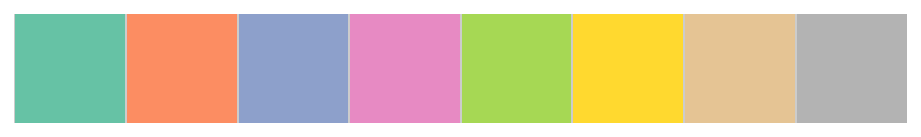

In [2]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,train_test_split
import random
import math
import time
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
sns.set_style('whitegrid')
sns.set_palette("Set2")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.palplot(sns.color_palette())


In [3]:
Confirmed_cases= pd.read_csv("/content/drive/My Drive/Colab/time_series_19-covid-Confirmed.csv")

deaths_reported= pd.read_csv("/content/drive/My Drive/Colab/time_series_19-covid-Deaths.csv")

Recovered_cases= pd.read_csv("/content/drive/My Drive/Colab/time_series_19-covid-Recovered.csv")

# pd.set_option('display.max_columns', None,'display.max_rows',None)


In [4]:
Confirmed_cases


,Country/Region,Province/State,Long,Lat,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/7/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,...,10/7/2020,10/8/2020,10/9/2020,10/10/2020,10/11/2020,10/12/2020,10/13/2020,10/14/2020,10/15/2020,10/16/2020,10/17/2020,10/18/2020,10/19/2020,10/20/2020,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020,10/31/2020,11/1/2020,11/2/2020,11/3/2020,11/4/2020,11/5/2020,11/6/2020,11/7/2020,11/8/2020,11/9/2020,11/10/2020,11/11/2020,11/12/2020,11/13/2020,11/14/2020,11/15/2020
0,Afghanistan,NaN,65.000000,33.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,39548,39616,39693,39703,39799,39870,39928,39994,40026,40073,40141,40200,40287,40357,40510,40626,40687,40768,40833,40937,41032,41145,41268,41334,41425,41501,41633,41728,41814,41935,41975,42033,42092,42297,42463,42609,42795,42969,43035,43240
1,Albania,NaN,20.168300,41.153300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14730,14899,15066,15231,15399,15570,15752,15955,16212,16501,16774,17055,17350,17651,17948,18250,18556,18858,19157,19445,19729,20040,20315,20634,20875,21202,21523,21904,22300,22721,23210,23705,24206,24731,25294,25801,26211,26701,27233,27830
2,Algeria,NaN,1.659600,28.033900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,52520,52658,52804,52940,53072,53325,53399,53584,53777,53998,54203,54402,54616,54829,55081,55357,55630,55880,56143,56419,56706,57026,57332,57651,57942,58272,58574,58979,59527,60169,60800,61381,62051,62693,63446,64257,65108,65975,66819,67679
3,Andorra,NaN,1.521800,42.506300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2568,2568,2696,2696,2696,2995,2995,3190,3190,3377,3377,3377,3623,3623,3811,3811,4038,4038,4038,4325,4410,4517,4567,4665,4756,4825,4888,4910,5045,5135,5135,5319,5383,5437,5477,5567,5616,5725,5725,5872
4,Angola,NaN,17.873900,-11.202700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5725,5958,6031,6246,6366,6488,6680,6846,7096,7222,7462,7622,7829,8049,8338,8582,8829,9026,9381,9644,9871,10074,10269,10558,10805,11035,11228,11577,11813,12102,12223,12335,12433,12680,12816,12953,13053,13228,13374,13451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,West Bank and Gaza,NaN,35.233200,31.952200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,42840,43256,43664,43945,44299,44684,45200,45658,46100,46434,46746,47135,47616,48129,48628,49134,49579,49989,50442,50952,51528,51948,52571,53075,53520,54060,54775,55408,56090,56672,57226,57657,58158,58838,59422,60065,60784,61514,62167,63031
795,Western Sahara,NaN,-12.885800,24.215500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
796,Yemen,NaN,48.516388,15.552727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2049,2050,2051,2051,2052,2052,2053,2053,2053,2055,2055,2056,2056,2057,2057,2057,2060,2060,2060,2060,2060,2061,2062,2062,2063,2063,2063,2063,2063,2063,2067,2070,2070,2071,2071,2071,2071,2072,2072,2072
797,Zambia,NaN,28.283300,-15.416700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15224,15301,15339,15415,15458,15549,15587,15616,15659,15659,15789,15853,15897,15982,16000,16035,16095,16117,16117,16200,16243,16285,1

In [5]:
deaths_reported

,Country/Region,Province/State,Long,Lat,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/7/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,...,10/7/2020,10/8/2020,10/9/2020,10/10/2020,10/11/2020,10/12/2020,10/13/2020,10/14/2020,10/15/2020,10/16/2020,10/17/2020,10/18/2020,10/19/2020,10/20/2020,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020,10/31/2020,11/1/2020,11/2/2020,11/3/2020,11/4/2020,11/5/2020,11/6/2020,11/7/2020,11/8/2020,11/9/2020,11/10/2020,11/11/2020,11/12/2020,11/13/2020,11/14/2020,11/15/2020
0,Afghanistan,NaN,65.000000,33.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1469,1470,1472,1473,1477,1479,1480,1481,1481,1485,1488,1492,1497,1499,1501,1505,1507,1511,1514,1518,1523,1529,1532,1533,1536,1536,1541,1544,1548,1554,1554,1556,1558,1574,1577,1581,1591,1595,1605,1617
1,Albania,NaN,20.168300,41.153300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,407,411,413,416,420,424,429,434,439,443,448,451,454,458,462,465,469,473,477,480,487,493,499,502,509,518,527,532,536,543,549,557,559,571,579,590,598,605,612,623
2,Algeria,NaN,1.659600,28.033900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1771,1783,1789,1795,1801,1809,1818,1827,1827,1841,1846,1856,1865,1873,1880,1888,1897,1907,1914,1922,1931,1941,1949,1956,1964,1973,1980,1980,1999,2011,2024,2036,2048,2062,2077,2093,2111,2124,2139,2154
3,Andorra,NaN,1.521800,42.506300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,53,54,55,55,55,57,57,59,59,59,59,59,62,62,63,63,69,69,69,72,72,72,73,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,76
4,Angola,NaN,17.873900,-11.202700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,211,208,212,218,218,219,222,227,228,234,241,247,248,251,255,260,265,267,268,270,271,275,275,279,284,286,289,291,296,299,300,303,307,308,308,312,315,317,322,322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,West Bank and Gaza,NaN,35.233200,31.952200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,355,359,367,378,381,387,391,393,401,402,402,408,413,421,427,435,439,443,448,454,458,465,473,481,483,489,493,501,504,508,511,512,515,521,533,538,542,548,558,565
795,Western Sahara,NaN,-12.885800,24.215500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
796,Yemen,NaN,48.516388,15.552727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,593,593,593,595,595,596,596,596,596,596,596,597,597,597,597,597,599,599,599,599,599,599,599,599,599,600,601,601,601,601,602,602,602,605,605,605,605,605,605,605
797,Zambia,NaN,28.283300,-15.416700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,335,335,336,337,337,345,345,345,346,346,346,346,346,346,346,346,346,348,348,348,348,348,348,349,349,349,349,349,349,349,349,349,349,349,350,350,350,350,350,353


In [6]:
Recovered_cases

,Country/Region,Province/State,Long,Lat,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/7/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,...,10/7/2020,10/8/2020,10/9/2020,10/10/2020,10/11/2020,10/12/2020,10/13/2020,10/14/2020,10/15/2020,10/16/2020,10/17/2020,10/18/2020,10/19/2020,10/20/2020,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020,10/31/2020,11/1/2020,11/2/2020,11/3/2020,11/4/2020,11/5/2020,11/6/2020,11/7/2020,11/8/2020,11/9/2020,11/10/2020,11/11/2020,11/12/2020,11/13/2020,11/14/2020,11/15/2020
0,Afghanistan,NaN,65.000000,33.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,33045,33058,33058,33064,33114,33118,33308,33354,33447,33516,33561,33614,33760,33790,33824,33831,34010,34023,34129,34150,34217,34237,34239,34258,34321,34326,34342,34355,34362,34440,34440,34446,34458,34721,34954,34967,35024,35036,35067,35092
1,Albania,NaN,20.168300,41.153300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9115,9215,9304,9406,9500,9585,9675,9762,9864,9957,10001,10071,10167,10225,10341,10395,10466,10548,10654,10705,10808,10893,11007,11097,11189,11246,11367,11473,11578,11696,11861,12002,12092,12203,12353,12493,12574,12667,12767,12889
2,Algeria,NaN,1.659600,28.033900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,36857,36958,37067,37170,37170,37382,37492,37603,37603,37856,37971,38088,38215,38346,38482,38618,38788,38932,39095,39273,39444,39635,39635,40014,40201,40395,40577,40577,41001,41244,41510,41783,42037,42325,42626,42980,42980,43779,44199,44633
3,Andorra,NaN,1.521800,42.506300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1715,1715,1814,1814,1814,1928,1928,2011,2011,2057,2057,2057,2273,2273,2470,2470,2729,2729,2729,2957,3029,3144,3260,3377,3475,3475,3548,3627,3734,3858,3858,4043,4248,4332,4405,4488,4585,4675,4675,4747
4,Angola,NaN,17.873900,-11.202700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2598,2635,2685,2716,2743,2744,2761,2801,2928,3012,3022,3030,3031,3037,3040,3305,3384,3461,3508,3530,3647,3693,3736,4107,4523,4920,5172,5230,5266,5350,5626,5647,5899,5927,6036,6125,6250,6326,6345,6444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,West Bank and Gaza,NaN,35.233200,31.952200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,35953,36584,36922,37240,37942,38228,38841,39304,39585,39921,40162,40498,40861,41455,41935,42544,42850,43232,43592,44055,44444,44985,45448,45896,46309,46773,47169,47744,48224,48680,49537,49975,50407,50877,51425,52226,52861,53367,53791,54346
795,Western Sahara,NaN,-12.885800,24.215500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
796,Yemen,NaN,48.516388,15.552727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1328,1329,1329,1329,1329,1329,1329,1329,1329,1335,1336,1338,1338,1338,1344,1344,1354,1360,1360,1360,1364,1366,1366,1366,1366,1366,1375,1375,1375,1375,1375,1375,1375,1394,1394,1394,1394,1394,1394,1394
797,Zambia,NaN,28.283300,-15.416700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14342,14365,14439,14541,14599,14682,14783,14850,14899,14899,14927,15005,15031,15038,15168,15168,15179,15179,15179,15445,15481,15559,15585,15600,15680,15733,15733,15763,15819,15827,15862,15873,15950,1601

In [7]:
#extracting all the columns using keys() fun
cols=Confirmed_cases.keys()
cols

Index(['Country/Region', 'Province/State', 'Long', 'Lat', '1/22/2020',
       '1/23/2020', '1/24/2020', '1/25/2020', '1/26/2020', '1/27/2020',
       ...
       '11/6/2020', '11/7/2020', '11/8/2020', '11/9/2020', '11/10/2020',
       '11/11/2020', '11/12/2020', '11/13/2020', '11/14/2020', '11/15/2020'],
      dtype='object', length=303)

In [8]:
# extracting only date colums
confirmed=Confirmed_cases.loc[:,cols[4]:cols[-1]]
death=deaths_reported.loc[:,cols[4]:cols[-1]]
recovered=Recovered_cases.loc[:,cols[4]:cols[-1]]

In [9]:
#finding total confirmed,death and recover cases
dates=confirmed.keys()
total_confirmed=[]
total_death=[]
total_recover=[]
for i in dates:
  world_cases=Confirmed_cases[i].sum()
  world_deaths=deaths_reported[i].sum()
  world_recovered=Recovered_cases[i].sum()

  # now appending value
  total_confirmed.append(world_cases)
  total_death.append(world_deaths)
  total_recover.append(world_recovered)


In [10]:
print(f"total confirmed cases {world_cases}")
print('*'*30)
print(f"total death cases {world_deaths}")
print('*'*30)
print(f"total recover cases {world_recovered}")


total confirmed cases 54370186
******************************
total death cases 1317139
******************************
total recover cases 34955148


In [11]:
#convert all the dates and cases in the numpy array
days=np.array([i for i in range(len(dates))]).reshape(-1,1)
total_confirmed=np.array(total_confirmed).reshape(-1,1)
world_deaths=np.array(world_deaths).reshape(-1,1)
world_recovered=np.array(world_recovered).reshape(-1,1)


In [12]:
#for prediction adding future dates
future_days=20
future_forecast=np.array([i for i in range(len(dates)+future_days)]).reshape(-1,1)
adjusted_dates=future_forecast[:-20]

In [13]:
#converting into dates

first='1/22/2020'
init_date=datetime.datetime.strptime(first,'%m/%d/%Y')
future_forecast_dates=[]
for i in range(len(future_forecast)):
  future_forecast_dates.append((init_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [14]:
#find the list of unique contries
unique_countries=list(Confirmed_cases['Country/Region'].unique())

unique_province=list(Confirmed_cases['Province/State'].unique())


In [15]:
Confirmed_cases['Province/State'].head(50)

0                              NaN
1                              NaN
2                              NaN
3                              NaN
4                              NaN
5                              NaN
6                              NaN
7                              NaN
8     Australian Capital Territory
9            From Diamond Princess
10                 New South Wales
11              Northern Territory
12                      Queensland
13                 South Australia
14                        Tasmania
15                        Victoria
16               Western Australia
17                             NaN
18                             NaN
19                             NaN
20                             NaN
21                             NaN
22                             NaN
23                             NaN
24                             NaN
25                         Antwerp
26                        Brussels
27                   East Flanders
28                 F

In [16]:
#for visualization 

latest_confirmed=Confirmed_cases[dates[-1]]
latest_deaths=deaths_reported[dates[-1]]
latest_recoveries=Recovered_cases[dates[-1]]
latest_confirmed

0      43240
1      27830
2      67679
3       5872
4      13451
       ...  
794    63031
795       10
796     2072
797    17123
798     8829
Name: 11/15/2020, Length: 799, dtype: int64

In [17]:
#now we will find total confirmed cases of each country
country_confirmed_cases=[]
no_cases=[]

for i in unique_countries:
  cases=latest_confirmed[Confirmed_cases['Country/Region']==i].sum()
  if cases>0:
    country_confirmed_cases.append(cases)
  else:
    no_cases.append(i)
 
for i in no_cases:
  unique_countries.remove(i)

unique_countries=[k for k,v in sorted(zip(unique_countries,country_confirmed_cases),key=operator.itemgetter(1),reverse=False)]
for i in range(len(unique_countries)):
  country_confirmed_cases[i]=latest_confirmed[Confirmed_cases['Country/Region']==unique_countries[i]].sum()
country_confirmed_cases

[1,
 1,
 9,
 10,
 16,
 19,
 24,
 27,
 30,
 32,
 35,
 68,
 78,
 134,
 148,
 160,
 162,
 250,
 302,
 375,
 431,
 478,
 493,
 509,
 548,
 579,
 602,
 602,
 628,
 712,
 965,
 985,
 1253,
 1281,
 1307,
 1507,
 1597,
 2001,
 2041,
 2072,
 2391,
 2419,
 2641,
 2675,
 2844,
 3003,
 3702,
 3875,
 3900,
 4030,
 4301,
 4823,
 4861,
 4900,
 5104,
 5189,
 5274,
 5455,
 5515,
 5649,
 5661,
 5872,
 5965,
 6080,
 6095,
 6684,
 7178,
 7186,
 7590,
 7637,
 7952,
 8034,
 8225,
 8829,
 9062,
 9168,
 9822,
 9884,
 10547,
 11610,
 11760,
 12204,
 12611,
 13451,
 13508,
 14448,
 14626,
 15793,
 16020,
 17123,
 17287,
 17310,
 19315,
 20976,
 22692,
 25931,
 27177,
 27749,
 27830,
 28434,
 28769,
 29117,
 34758,
 36358,
 43240,
 47050,
 47417,
 50123,
 55042,
 58119,
 62652,
 63031,
 65148,
 66983,
 67679,
 67903,
 68994,
 70243,
 70245,
 71574,
 71956,
 73602,
 74205,
 75688,
 79678,
 80404,
 84206,
 84568,
 84703,
 86767,
 89279,
 91850,
 97352,
 98251,
 102720,
 103102,
 105430,
 110767,
 114185,
 114885,


In [18]:
country_confirmed=pd.DataFrame({'case':country_confirmed_cases,'country':unique_countries})

In [19]:
#number of cases per country
for i in range(len(unique_countries)):
  print(f'{unique_countries[i]}:{country_confirmed_cases[i]} cases')

Marshall Islands:1 cases
Vanuatu:1 cases
MS Zaandam:9 cases
Western Sahara:10 cases
Solomon Islands:16 cases
Saint Kitts and Nevis:19 cases
Laos:24 cases
Holy See:27 cases
Timor-Leste:30 cases
Grenada:32 cases
Fiji:35 cases
Dominica:68 cases
Saint Vincent and the Grenadines:78 cases
Antigua and Barbuda:134 cases
Brunei:148 cases
Seychelles:160 cases
Saint Lucia:162 cases
Barbados:250 cases
Cambodia:302 cases
Bhutan:375 cases
Mongolia:431 cases
Mauritius:478 cases
Eritrea:493 cases
Tanzania:509 cases
Monaco:548 cases
Comoros:579 cases
Papua New Guinea:602 cases
Taiwan*:602 cases
Burundi:628 cases
Diamond Princess:712 cases
Sao Tome and Principe:965 cases
Liechtenstein:985 cases
San Marino:1253 cases
Vietnam:1281 cases
Niger:1307 cases
Liberia:1507 cases
Chad:1597 cases
New Zealand:2001 cases
Lesotho:2041 cases
Yemen:2072 cases
Sierra Leone:2391 cases
Guinea-Bissau:2419 cases
Burkina Faso:2641 cases
Togo:2675 cases
Benin:2844 cases
South Sudan:3003 cases
Gambia:3702 cases
Thailand:3875 c

In [20]:
#countries which are not province

outliers=['United Kingdom','Denmark','France']
for i in outliers:
  unique_province.remove(i)

In [21]:
province_confirmed_cases=[]
no_cases=[]

for i in unique_province:
  cases=latest_confirmed[Confirmed_cases['Province/State']==i].sum()
  if cases>0:
    province_confirmed_cases.append(cases)
  else:
    no_cases.append(i)

for i in no_cases:
  unique_province.remove(i)


In [22]:
#number of cases per province
for i in range(len(unique_province)):
  print(f'{unique_province[i]}:{province_confirmed_cases[i]} cases')

Australian Capital Territory:114 cases
New South Wales:4498 cases
Northern Territory:46 cases
Queensland:1185 cases
South Australia:544 cases
Tasmania:230 cases
Victoria:20345 cases
Western Australia:787 cases
Antwerp:62216 cases
Brussels:72592 cases
East Flanders:48444 cases
Flemish Brabant:41165 cases
Hainaut:86262 cases
Liege:87228 cases
Limburg:42750 cases
Luxembourg:14877 cases
Namur:30287 cases
Unknown:11959 cases
Walloon Brabant:21904 cases
West Flanders:40093 cases
Acre:33156 cases
Alagoas:92596 cases
Amapa:54979 cases
Amazonas:189761 cases
Bahia:374009 cases
Ceara:285301 cases
Distrito Federal:219992 cases
Espirito Santo:169928 cases
Goias:267603 cases
Maranhao:189590 cases
Mato Grosso:151582 cases
Mato Grosso do Sul:87935 cases
Minas Gerais:382882 cases
Para:261788 cases
Paraiba:138546 cases
Parana:239107 cases
Pernambuco:170860 cases
Piaui:120172 cases
Rio Grande do Norte:83646 cases
Rio Grande do Sul:278707 cases
Rio de Janeiro:326956 cases
Rondonia:75182 cases
Roraima:6053

In [23]:
# new_data=pd.DataFrame({'total_confirmed':total_confirmed,'total_death':total_death,'total_recover':total_recover})
country_cases=pd.DataFrame({'unique_country':unique_countries,'country_confirmed_cases':country_confirmed_cases})


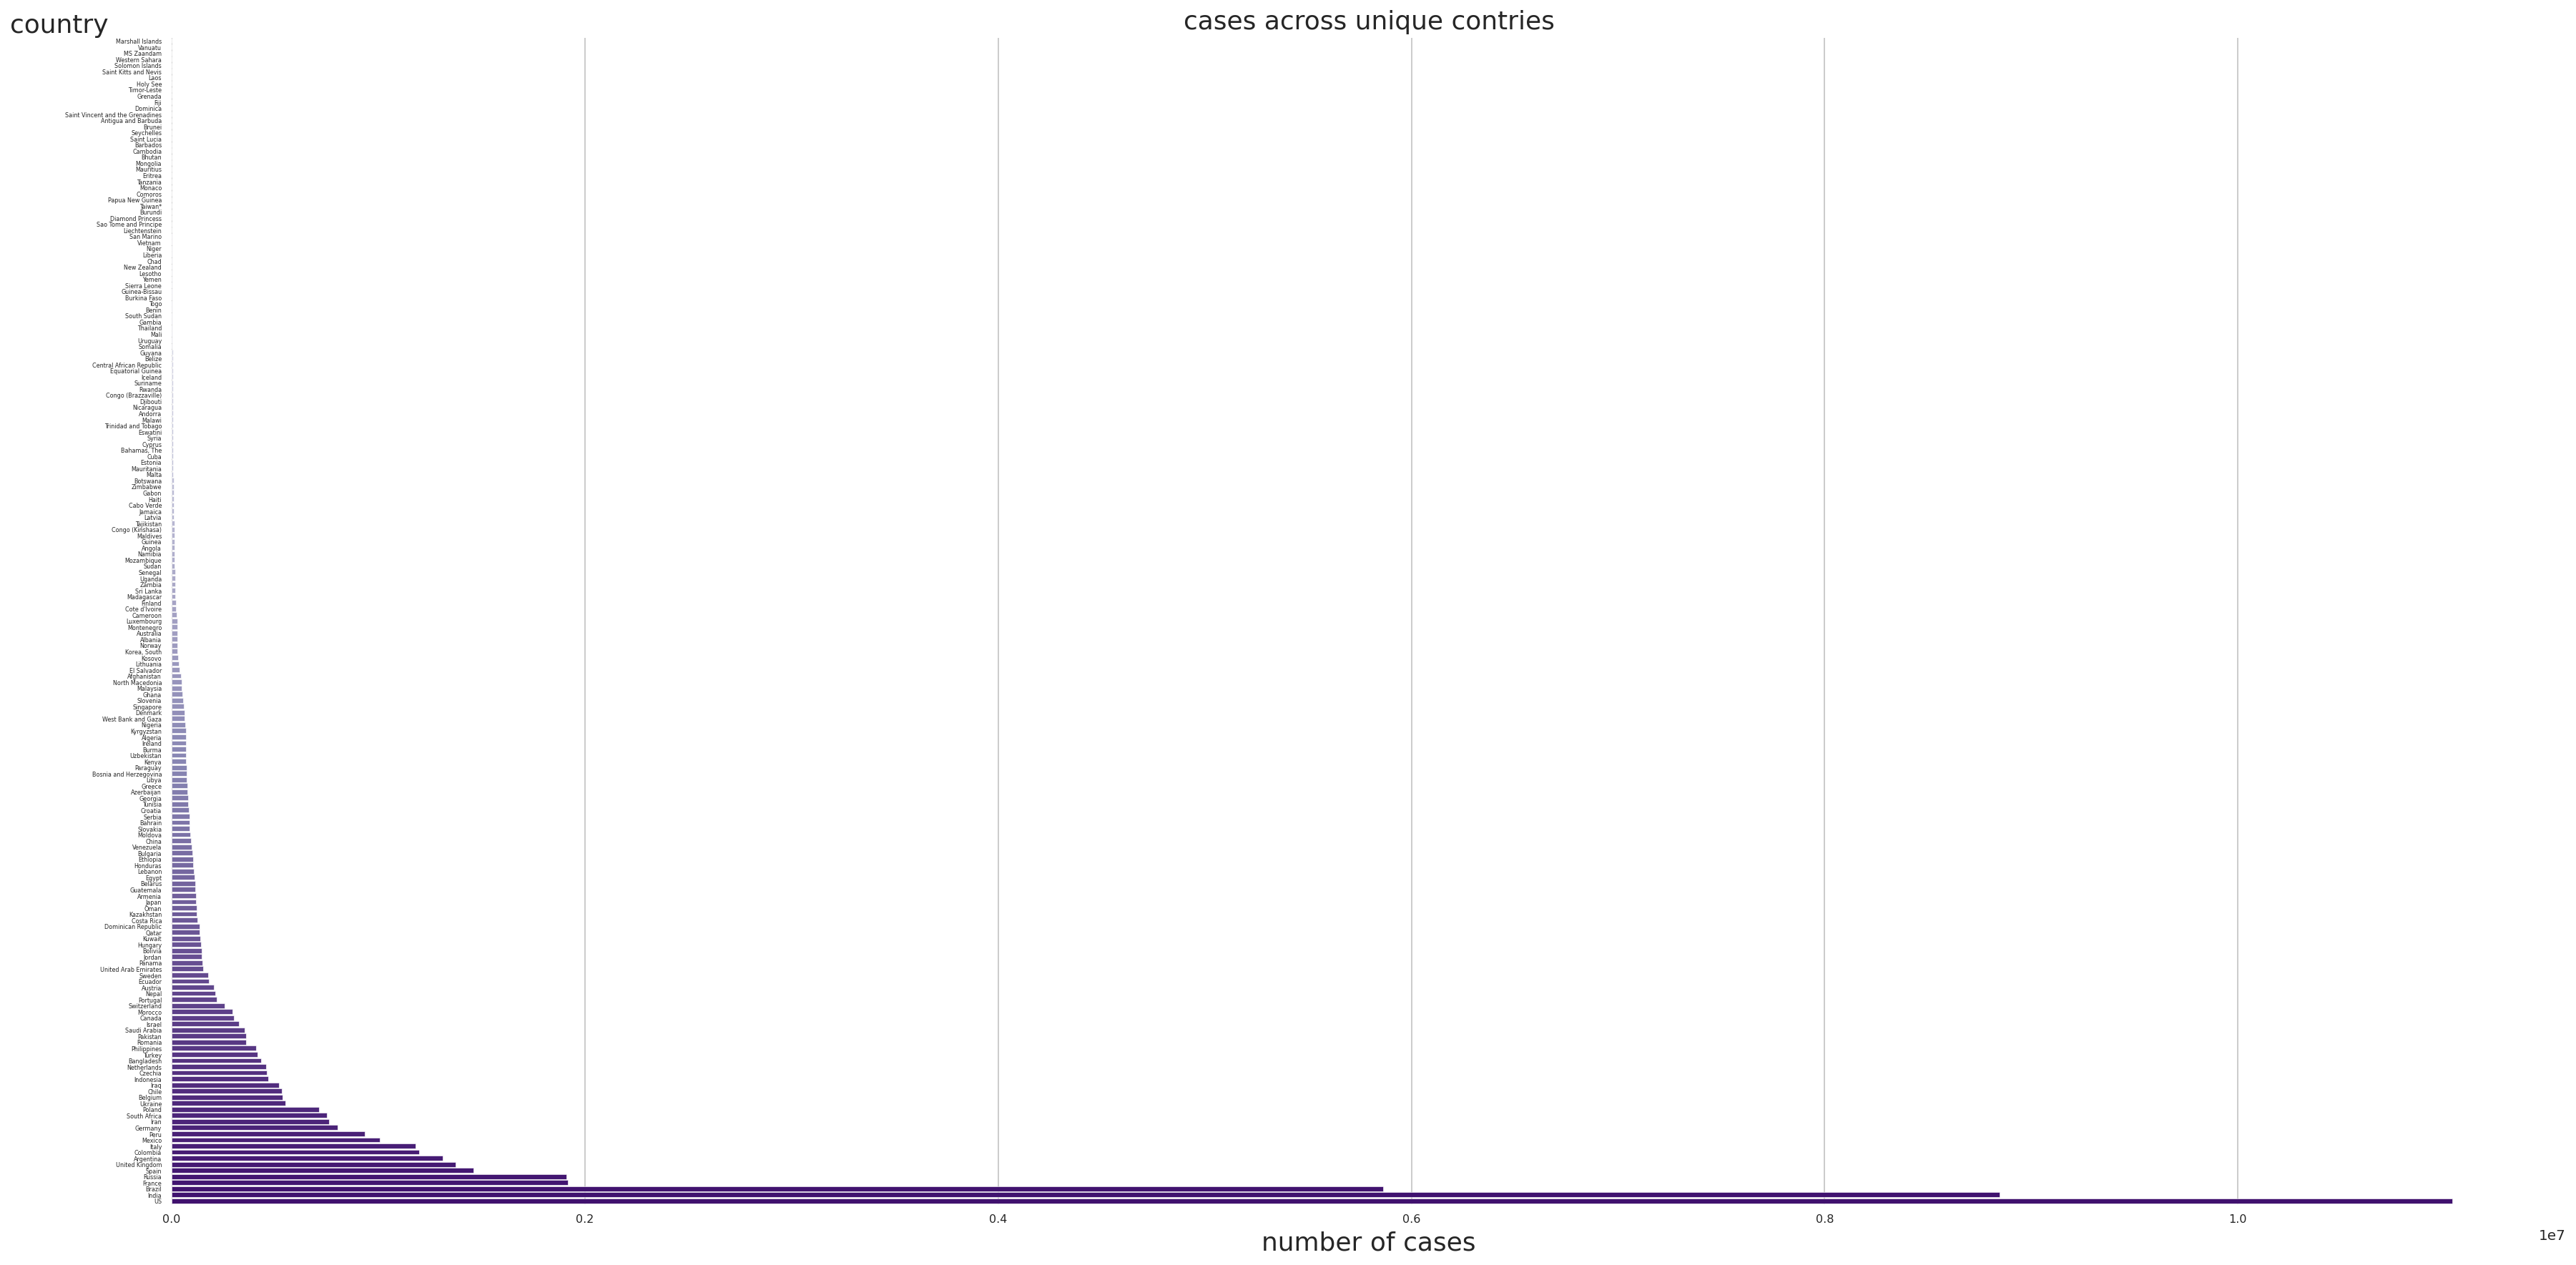

In [24]:
plt.figure(figsize=(30,15))
fig = sns.barplot(y='unique_country',x='country_confirmed_cases',data=country_cases,palette=sns.color_palette("Purples", n_colors=len(unique_countries)))
fig.set_title('cases across unique contries',fontsize=18)
fig.set_xlabel('number of cases', fontsize=18)
fig.set_ylabel('country', fontsize=18, position=(0,1), rotation=0)
plt.xticks(fontsize=8, rotation=0)
plt.yticks(fontsize=4)
plt.show()


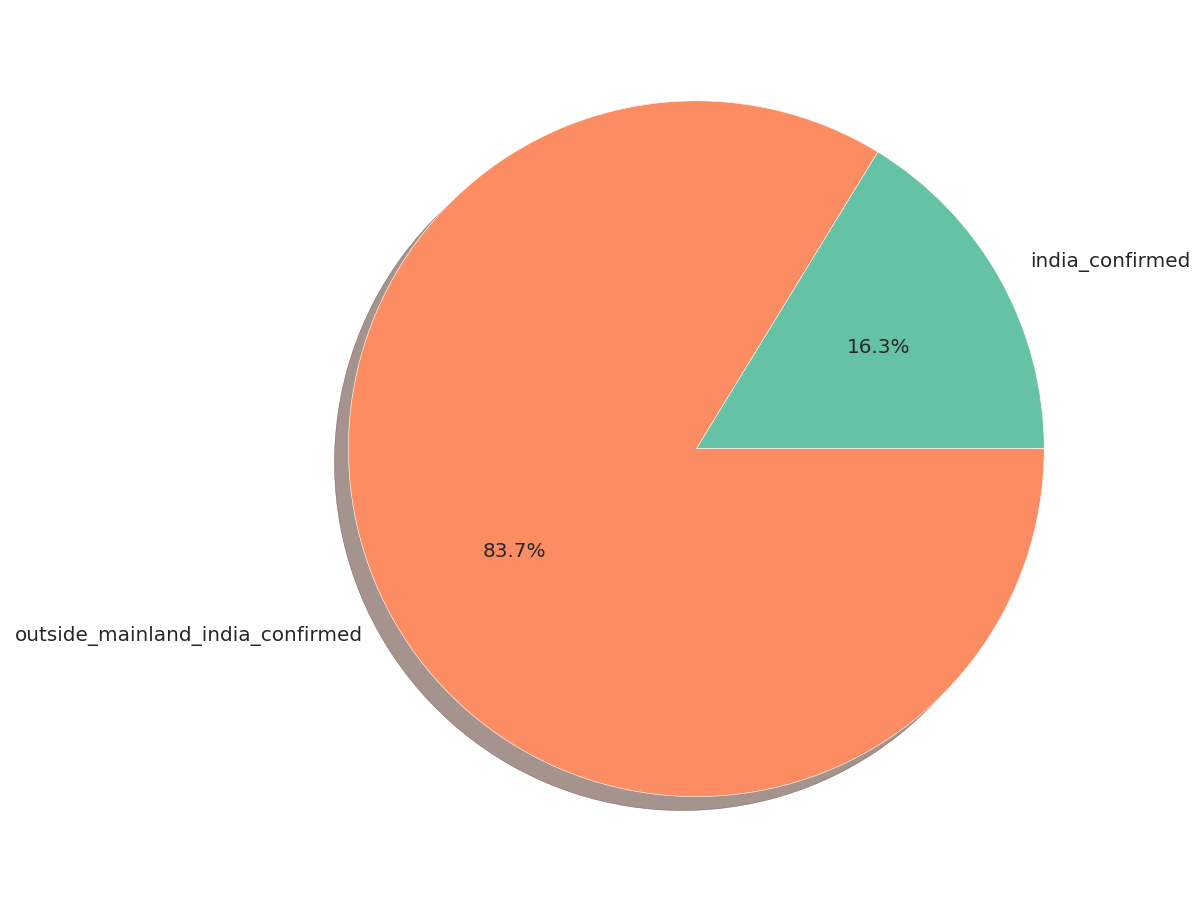

In [25]:
#  plot for total confirmed cases of mainland and outsideland of india

india_confirmed=latest_confirmed[Confirmed_cases['Country/Region']=='India'].sum()
outside_mainland_india_confirmed=(np.sum(country_confirmed_cases))-(india_confirmed)

plt.figure(figsize=(12,8))
plt.pie([india_confirmed,outside_mainland_india_confirmed],labels=['india_confirmed','outside_mainland_india_confirmed'],autopct='%1.1f%%',shadow=True)
plt.show()

# Adjusting the bin size can alter the look of your graph, worth testing different sizes to see various plots


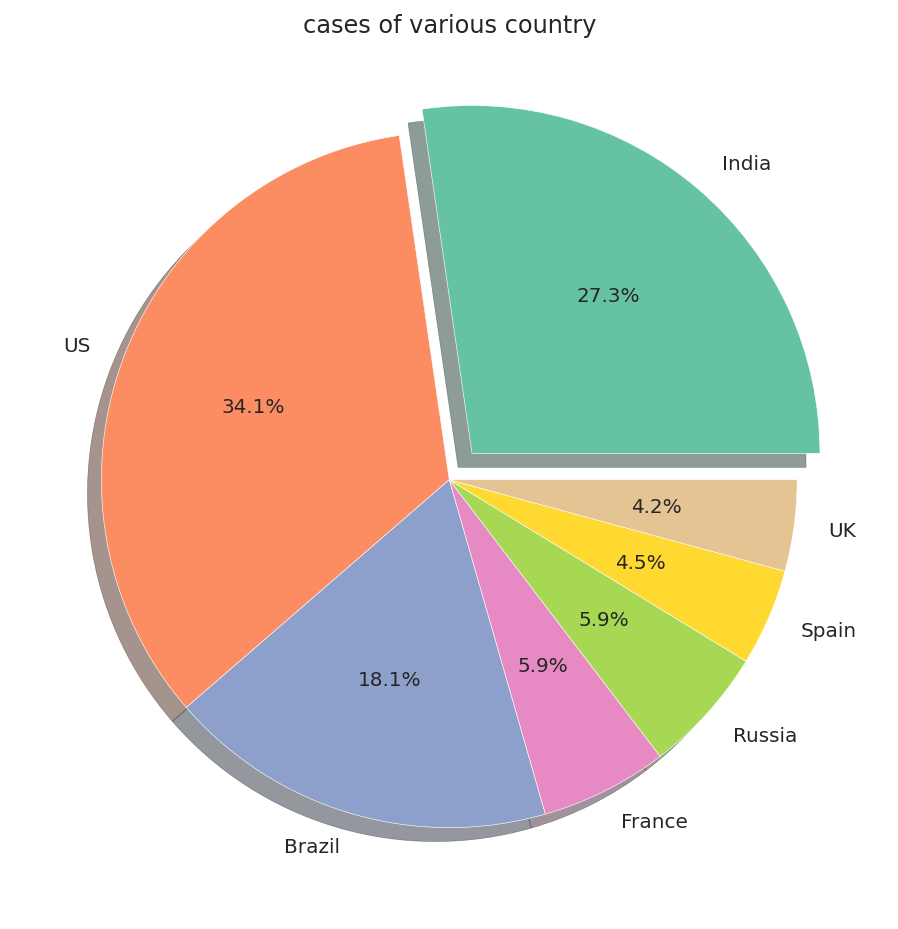

In [26]:
# total confirmed case across top country
india_confirmed=latest_confirmed[Confirmed_cases['Country/Region']=='India'].sum()
us_confirmed=latest_confirmed[Confirmed_cases['Country/Region']=='US'].sum()
brazil_confirmed=latest_confirmed[Confirmed_cases['Country/Region']=='Brazil'].sum()
france_confirmed=latest_confirmed[Confirmed_cases['Country/Region']=='France'].sum()
russia_confirmed=latest_confirmed[Confirmed_cases['Country/Region']=='Russia'].sum()
spain_confirmed=latest_confirmed[Confirmed_cases['Country/Region']=='Spain'].sum()
uk_confirmed=latest_confirmed[Confirmed_cases['Country/Region']=='United Kingdom'].sum()

plt.figure(figsize=(12,8))
plt.pie([india_confirmed,us_confirmed,brazil_confirmed,france_confirmed,russia_confirmed,spain_confirmed,uk_confirmed],labels=['India','US','Brazil','France','Russia','Spain','UK'],explode=[0.1,0,0,0,0,0,0],autopct='%1.1f%%',shadow=True)
plt.title('cases of various country')
plt.show()



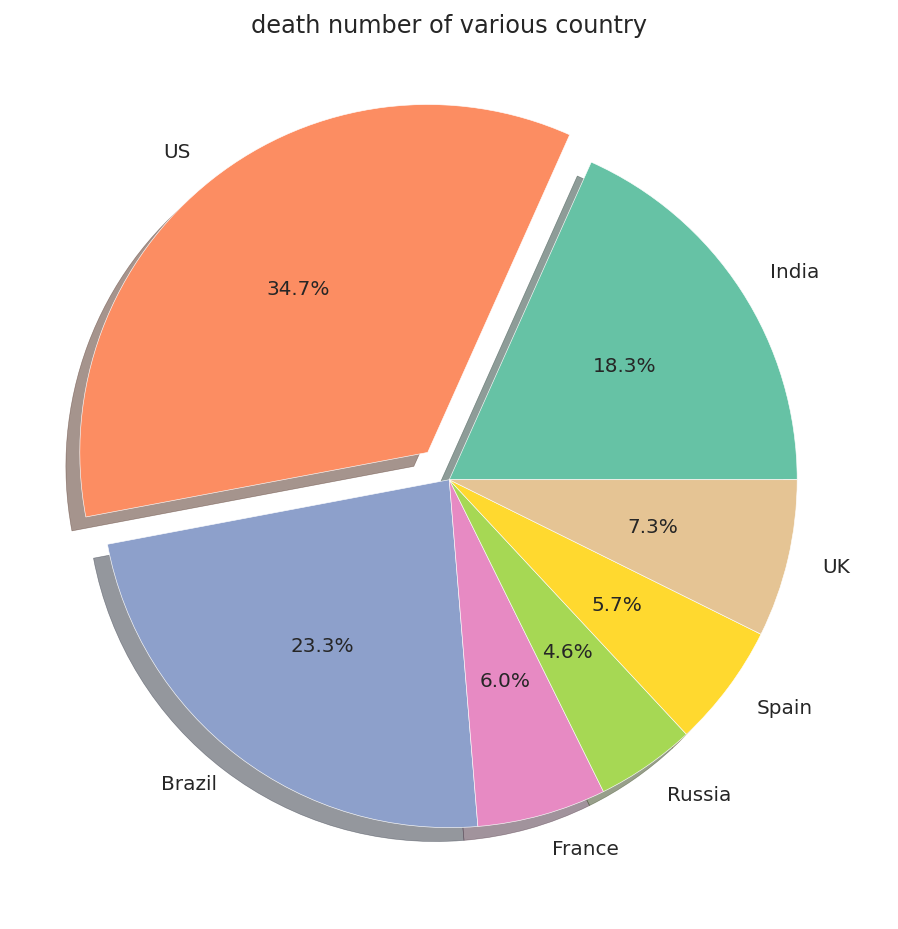

In [27]:
#plot top country total death 
india_confirmed=latest_deaths[Confirmed_cases['Country/Region']=='India'].sum()
us_confirmed=latest_deaths[Confirmed_cases['Country/Region']=='US'].sum()
brazil_confirmed=latest_deaths[Confirmed_cases['Country/Region']=='Brazil'].sum()
france_confirmed=latest_deaths[Confirmed_cases['Country/Region']=='France'].sum()
russia_confirmed=latest_deaths[Confirmed_cases['Country/Region']=='Russia'].sum()
spain_confirmed=latest_deaths[Confirmed_cases['Country/Region']=='Spain'].sum()
uk_confirmed=latest_deaths[Confirmed_cases['Country/Region']=='United Kingdom'].sum()

plt.figure(figsize=(12,8))
plt.pie([india_confirmed,us_confirmed,brazil_confirmed,france_confirmed,russia_confirmed,spain_confirmed,uk_confirmed],labels=['India','US','Brazil','France','Russia','Spain','UK'],explode=[0,0.1,0,0,0,0,0],autopct='%1.1f%%',shadow=True)
plt.title('death number of various country')
plt.show()



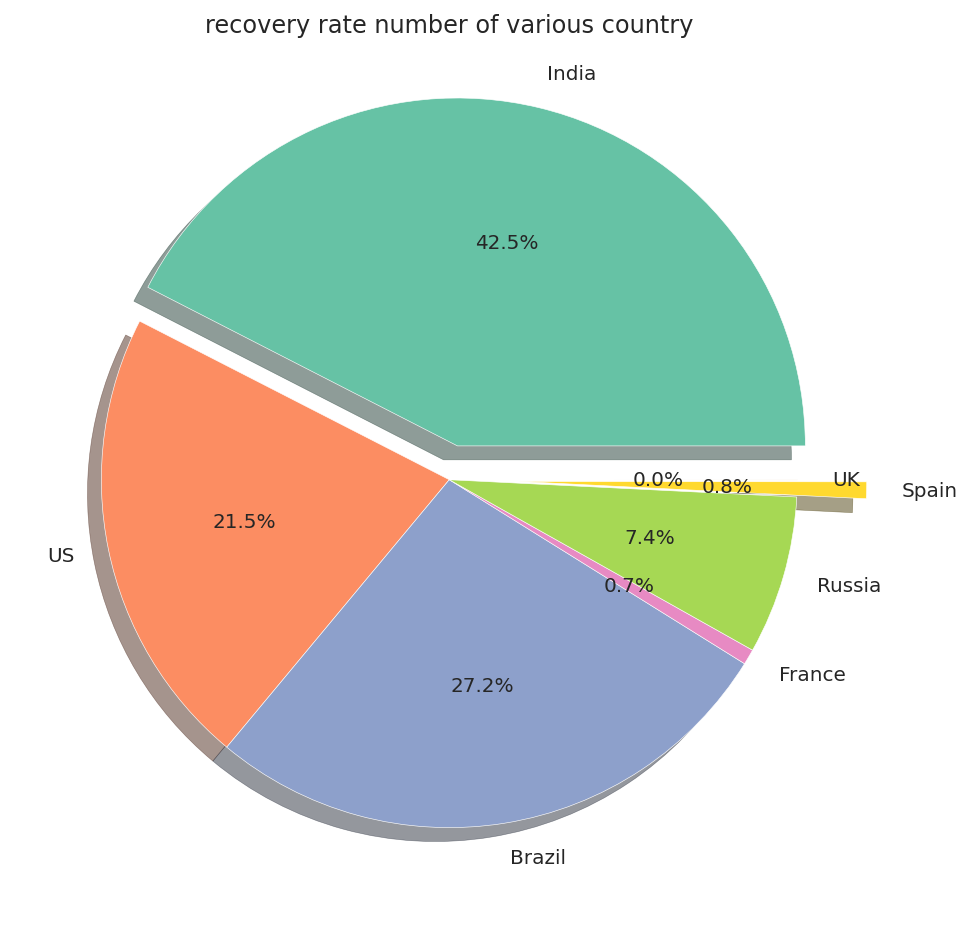

In [28]:
#plot top country total recovery 
india_confirmed=latest_recoveries[Confirmed_cases['Country/Region']=='India'].sum()
us_confirmed=latest_recoveries[Confirmed_cases['Country/Region']=='US'].sum()
brazil_confirmed=latest_recoveries[Confirmed_cases['Country/Region']=='Brazil'].sum()
france_confirmed=latest_recoveries[Confirmed_cases['Country/Region']=='France'].sum()
russia_confirmed=latest_recoveries[Confirmed_cases['Country/Region']=='Russia'].sum()
spain_confirmed=latest_recoveries[Confirmed_cases['Country/Region']=='Spain'].sum()
uk_confirmed=latest_recoveries[Confirmed_cases['Country/Region']=='United Kingdom'].sum()

plt.figure(figsize=(12,8))
plt.pie([india_confirmed,us_confirmed,brazil_confirmed,france_confirmed,russia_confirmed,spain_confirmed,uk_confirmed],labels=['India','US','Brazil','France','Russia','Spain','UK'],explode=[0.1,0,0,0,0,0.2,0],autopct='%1.1f%%',shadow=True)
plt.title('recovery rate number of various country')
plt.show()



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

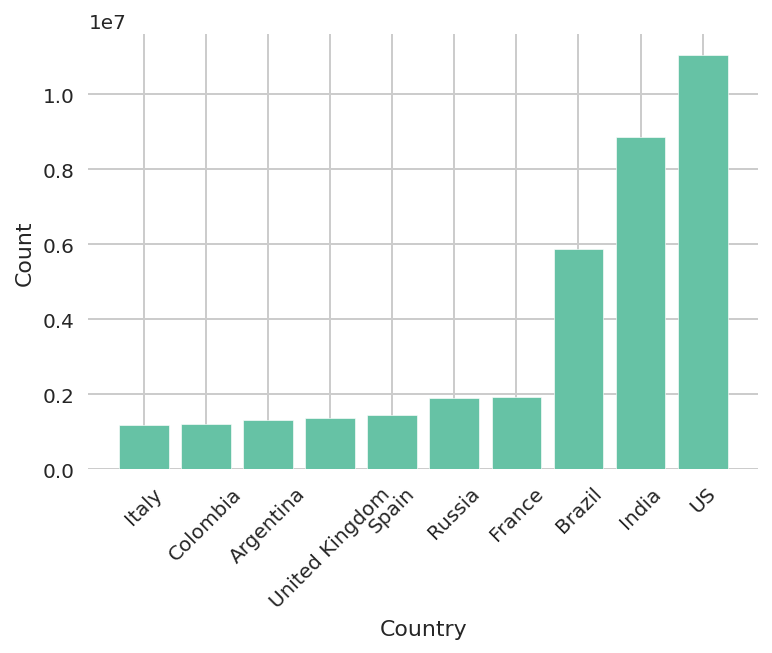

In [29]:
#top 10 countries confirmed cases
plt.bar(country_confirmed['country'][-10:],country_confirmed['case'][-10:])
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)

In [30]:
x_train_confirmed,x_test_confirmed,y_train_confirmed,y_test_confirmed=train_test_split(days,total_confirmed,test_size=0.25,shuffle=False)

In [31]:
#building the svm model
kernel=['poly','sigmoid','rbf']
c=[0.01,0.1,1,10]
# gamma=['scale','auto']
epsilon=[0.01,0.1,1]
shrinking=[True,False]
svm_grid={'kernel':kernel,'C':c,'epsilon':epsilon,'shrinking':shrinking}

svm=SVR()
svm_search=RandomizedSearchCV(svm,svm_grid,scoring='neg_mean_squared_error',cv=3,return_train_score=True,n_jobs=3,n_iter=40,verbose=1)


In [32]:
svm_search.fit(x_train_confirmed,y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 103 tasks      | elapsed:    1.9s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    2.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=3,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [33]:
svm_search.best_params_

{'C': 10, 'epsilon': 0.01, 'kernel': 'poly', 'shrinking': False}

In [34]:
svm_confirmed=svm_search.best_estimator_

In [35]:
svm_pred=svm_confirmed.predict(future_forecast)


In [36]:
svm_pred

array([4200843.24372613, 4200843.31848974, 4200843.84183499,
       4200845.26234353, 4200848.028597  , 4200852.58917705,
       4200859.39266532, 4200868.88764346, 4200881.5226931 ,
       4200897.7463959 , 4200918.0073335 , 4200942.75408754,
       4200972.43523967, 4201007.49937152, 4201048.39506475,
       4201095.570901  , 4201149.47546192, 4201210.55732914,
       4201279.26508431, 4201356.04730908, 4201441.35258509,
       4201535.62949398, 4201639.32661741, 4201752.892537  ,
       4201876.77583441, 4202011.42509129, 4202157.28888926,
       4202314.81580999, 4202484.45443511, 4202666.65334627,
       4202861.86112512, 4203070.52635329, 4203293.09761243,
       4203530.02348418, 4203781.7525502 , 4204048.73339212,
       4204331.41459158, 4204630.24473024, 4204945.67238973,
       4205278.14615171, 4205628.1145978 , 4205996.02630967,
       4206382.32986895, 4206787.47385729, 4207211.90685633,
       4207656.07744771, 4208120.43421309, 4208605.4257341 ,
       4209111.50059238,

MAE: 32465548.161246154
MSE: 1114359287359566.8


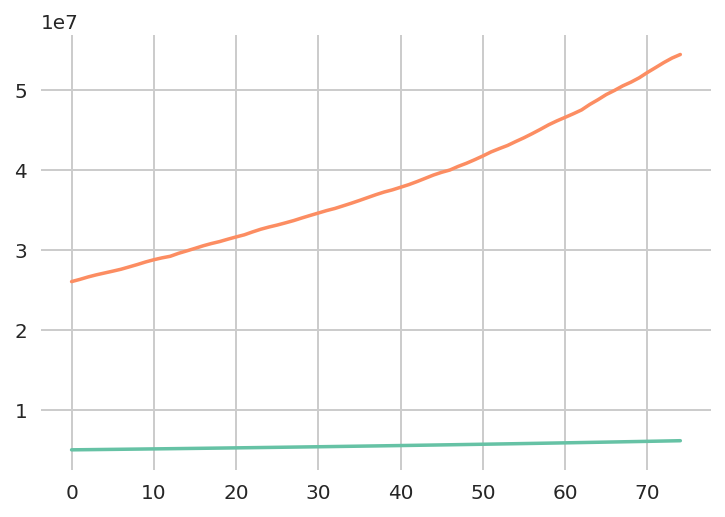

In [37]:
#checking against testing data
svm_test_pred=svm_confirmed.predict(x_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:',mean_absolute_error(svm_test_pred,y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred,y_test_confirmed))

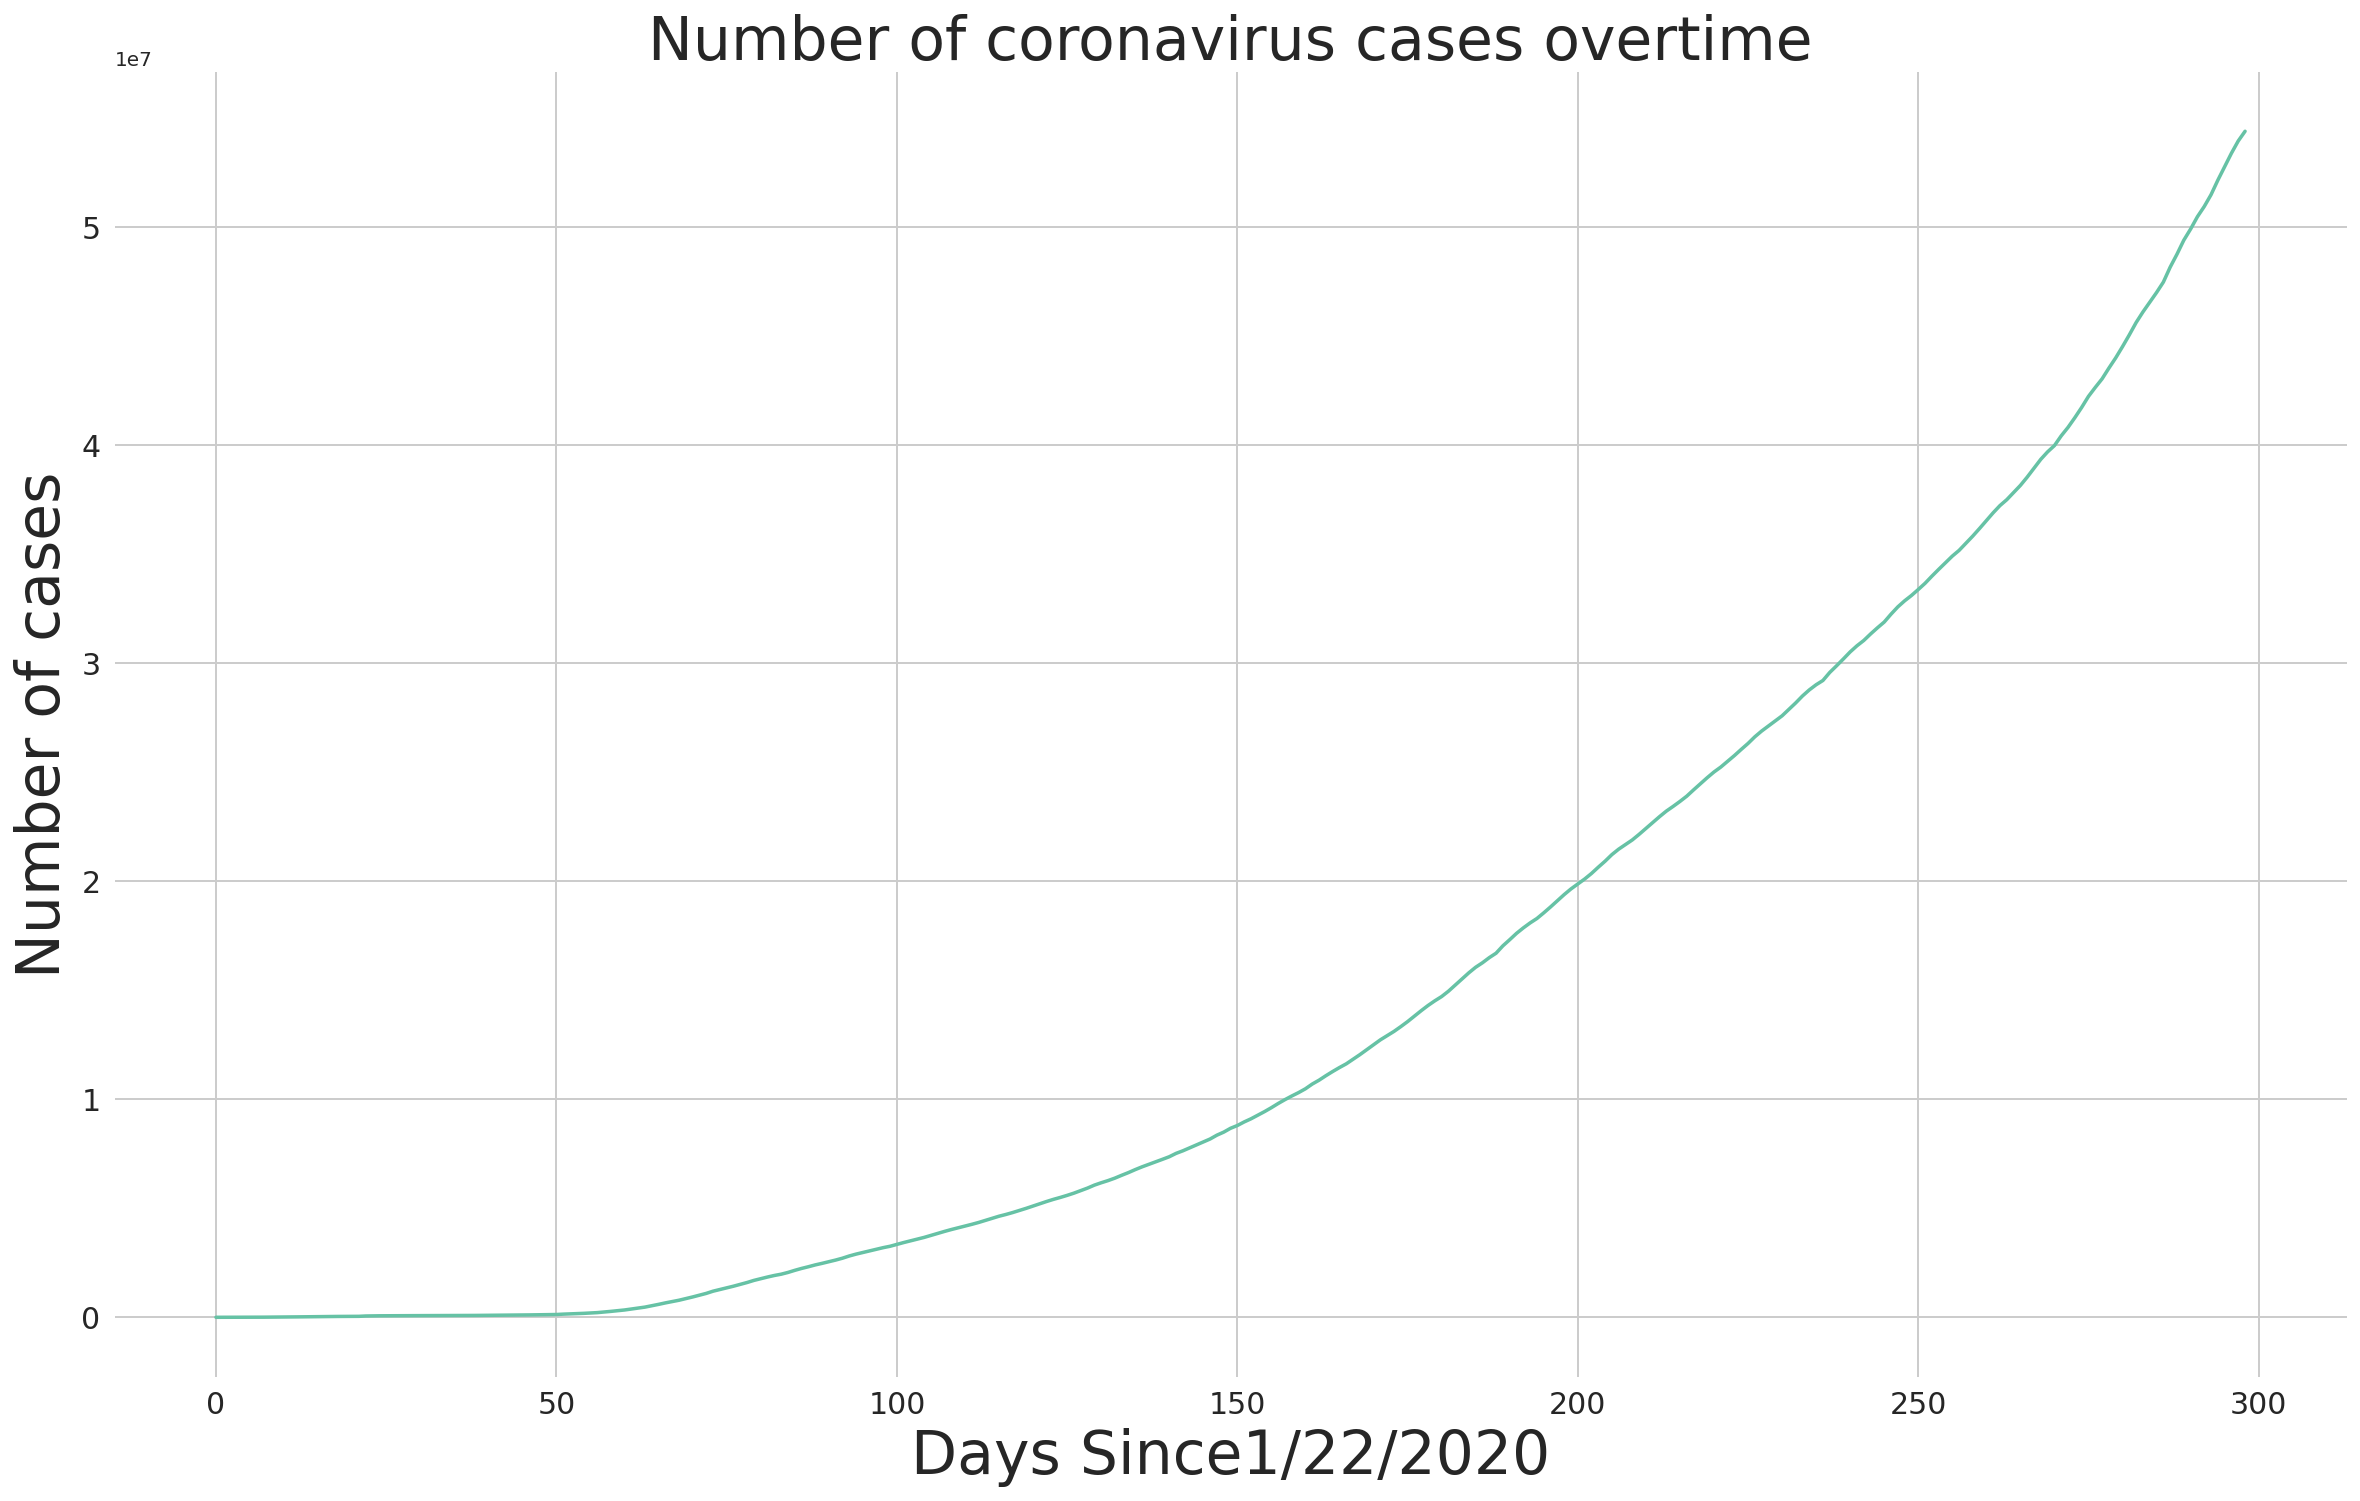

In [38]:
plt.figure(figsize=(20,12))
plt.plot(adjusted_dates,total_confirmed)
plt.title('Number of coronavirus cases overtime',size=30)
plt.xlabel('Days Since1/22/2020',size=30)
plt.ylabel('Number of cases',size=30)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

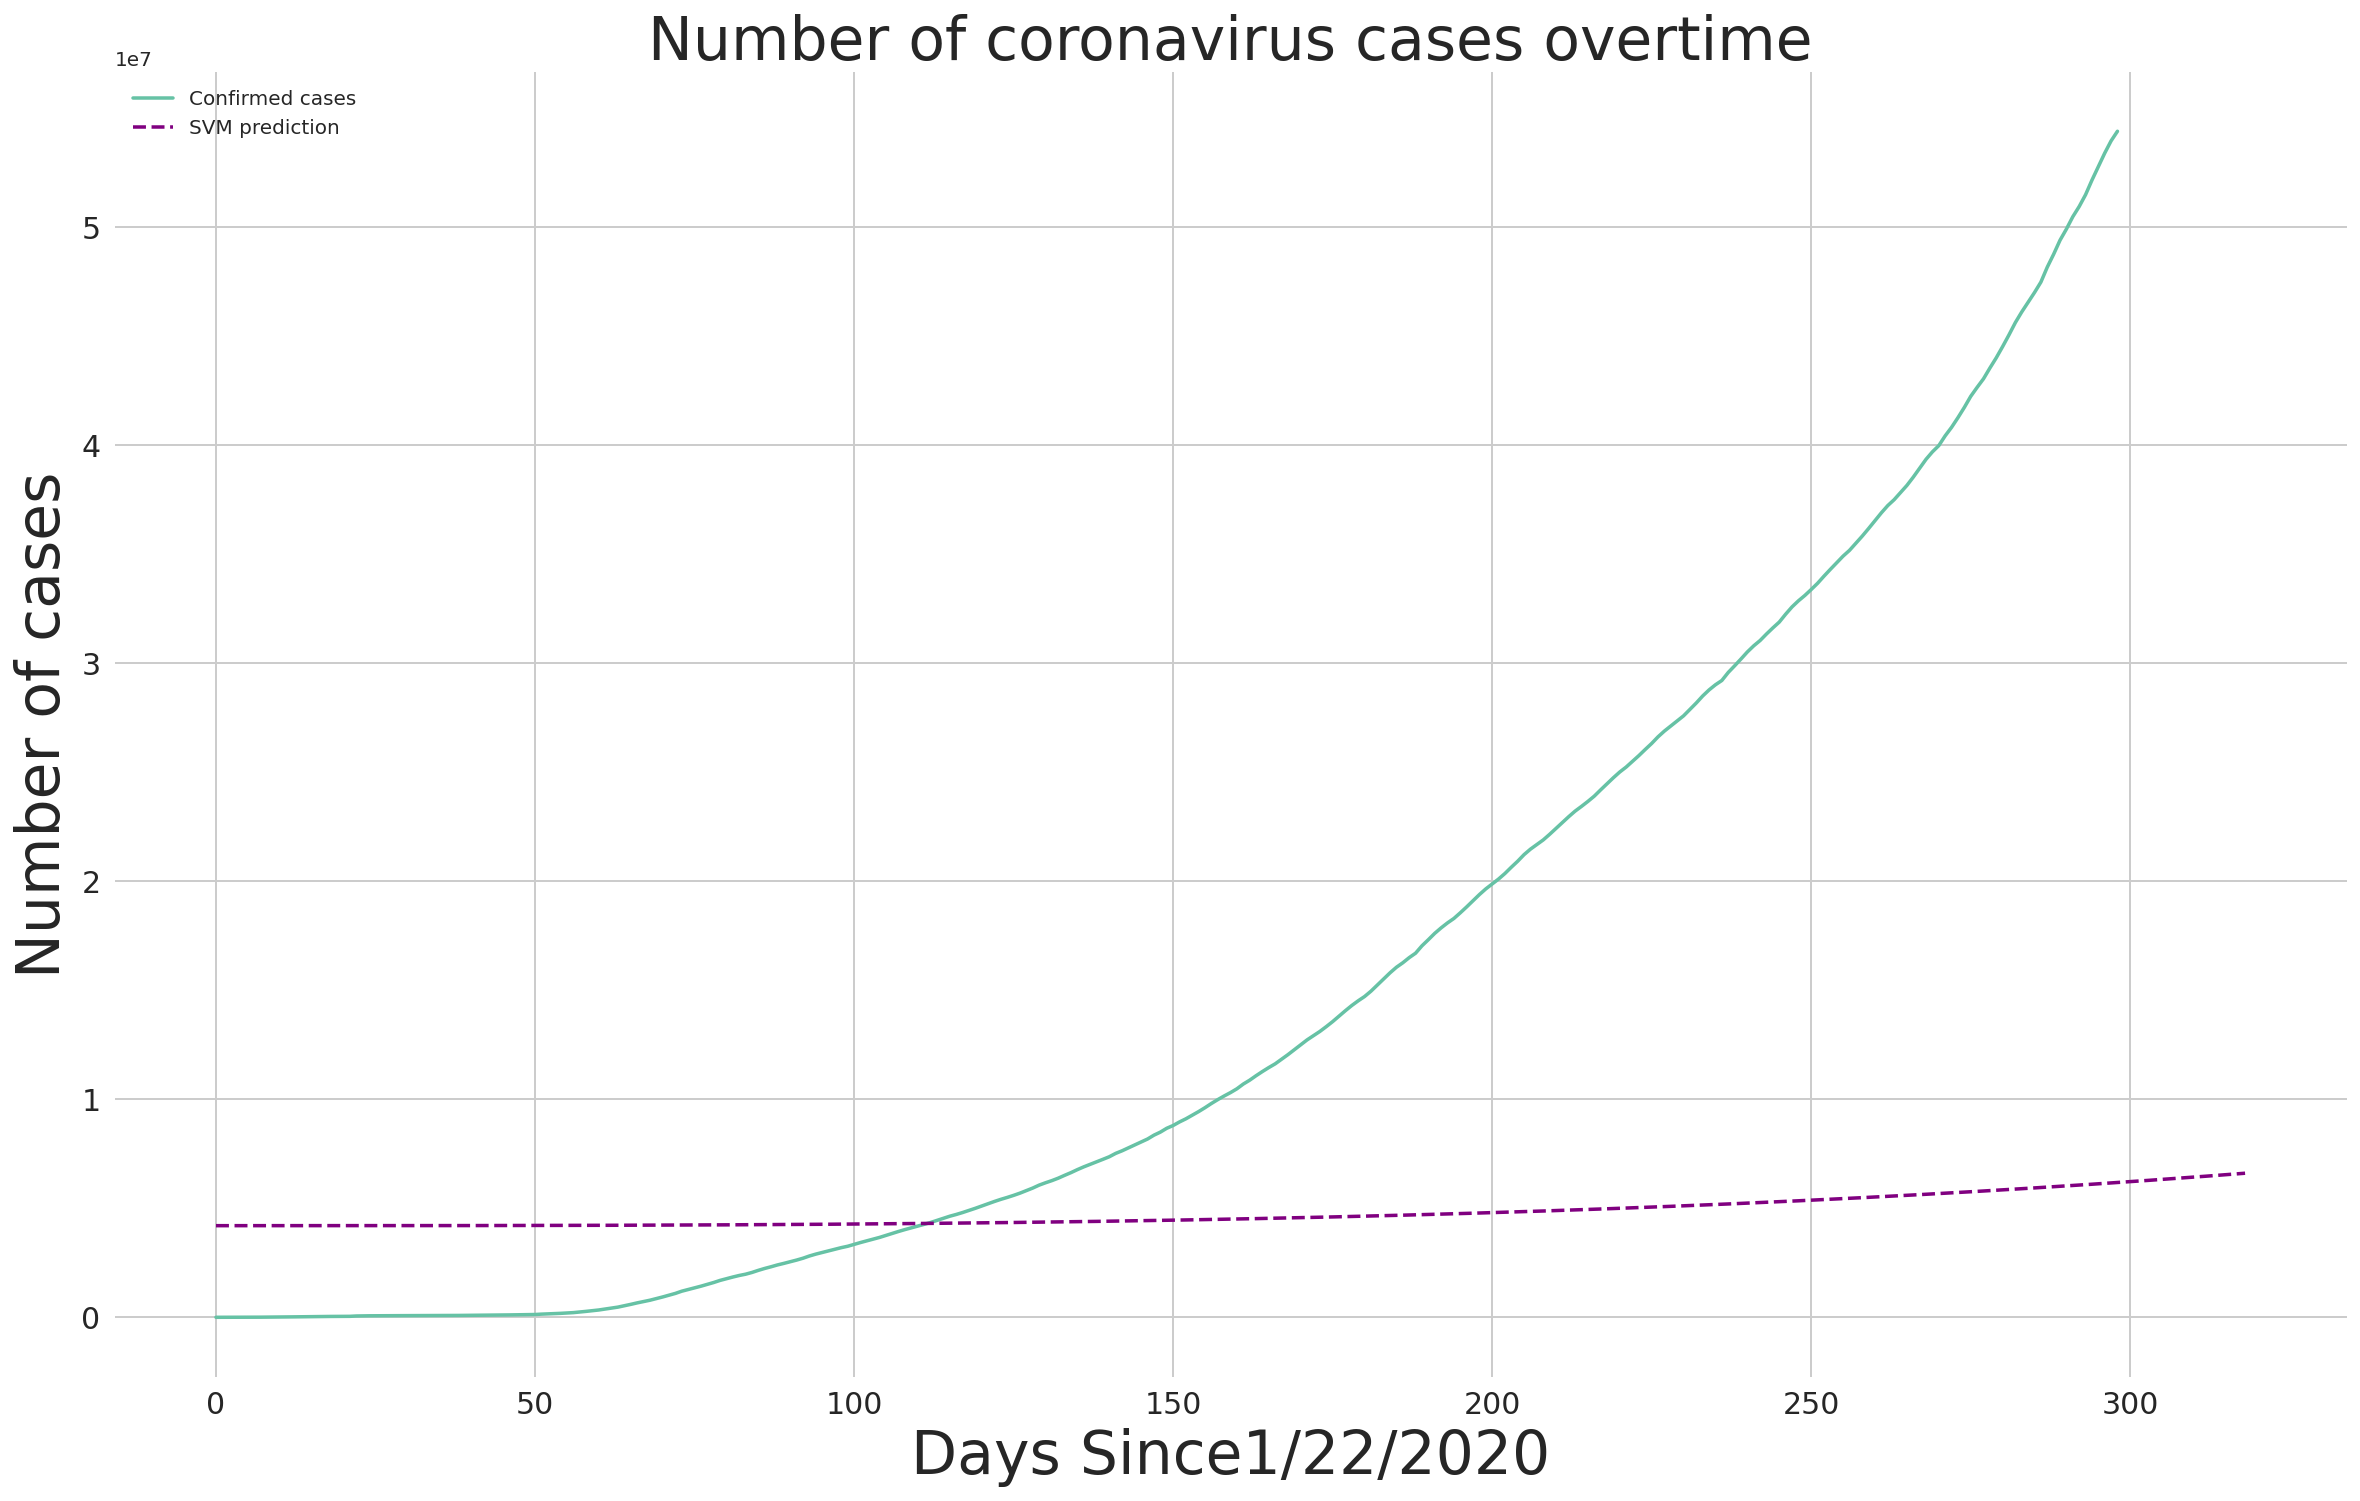

In [39]:
# confirmed vs predicted
plt.figure(figsize=(20,12))
plt.plot(adjusted_dates,total_confirmed)
plt.plot(future_forecast,svm_pred,linestyle='dashed',color='purple')
plt.title('Number of coronavirus cases overtime',size=30)
plt.xlabel('Days Since1/22/2020',size=30)
plt.ylabel('Number of cases',size=30)
plt.legend(['Confirmed cases','SVM prediction'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [40]:
#prediction for the next 10 days using svm

set(zip(future_forecast_dates[-20:],svm_pred[-20:]))

{('11/16/2020', 6199341.681206995),
 ('11/17/2020', 6219460.642713846),
 ('11/18/2020', 6239714.178713963),
 ('11/19/2020', 6260102.73778899),
 ('11/20/2020', 6280626.768520572),
 ('11/21/2020', 6301286.719490353),
 ('11/22/2020', 6322083.039279977),
 ('11/23/2020', 6343016.176471086),
 ('11/24/2020', 6364086.579645326),
 ('11/25/2020', 6385294.697384344),
 ('11/26/2020', 6406640.97826978),
 ('11/27/2020', 6428125.8708832795),
 ('11/28/2020', 6449749.823806488),
 ('11/29/2020', 6471513.285621048),
 ('11/30/2020', 6493416.704908606),
 ('12/01/2020', 6515460.530250801),
 ('12/02/2020', 6537645.210229284),
 ('12/03/2020', 6559971.193425696),
 ('12/04/2020', 6582438.92842168),
 ('12/05/2020', 6605048.863798883)}

In [41]:
from sklearn.linear_model import LinearRegression
linear_model=LinearRegression(normalize=True,fit_intercept=True)
linear_model.fit(x_train_confirmed,y_train_confirmed)

test_linear_pred=linear_model.predict(x_test_confirmed)
linear_pred=linear_model.predict(future_forecast)
print('MAE:',mean_absolute_error(test_linear_pred,y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred,y_test_confirmed))

MAE: 14417188.642766917
MSE: 240852868655132.75


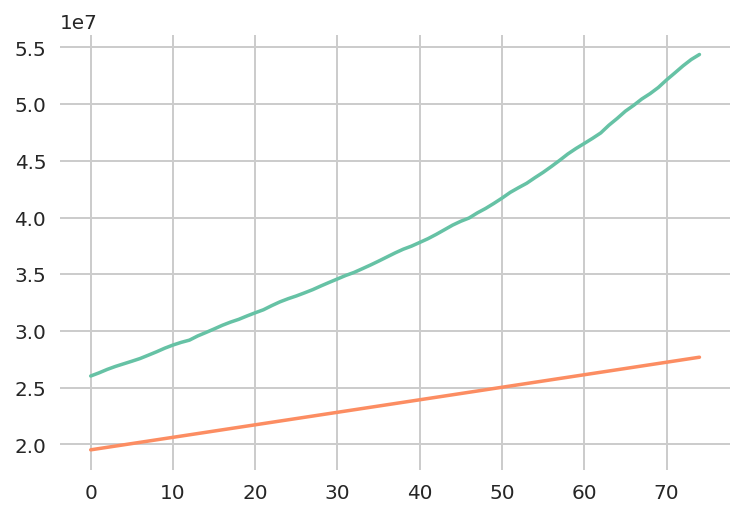

In [42]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)

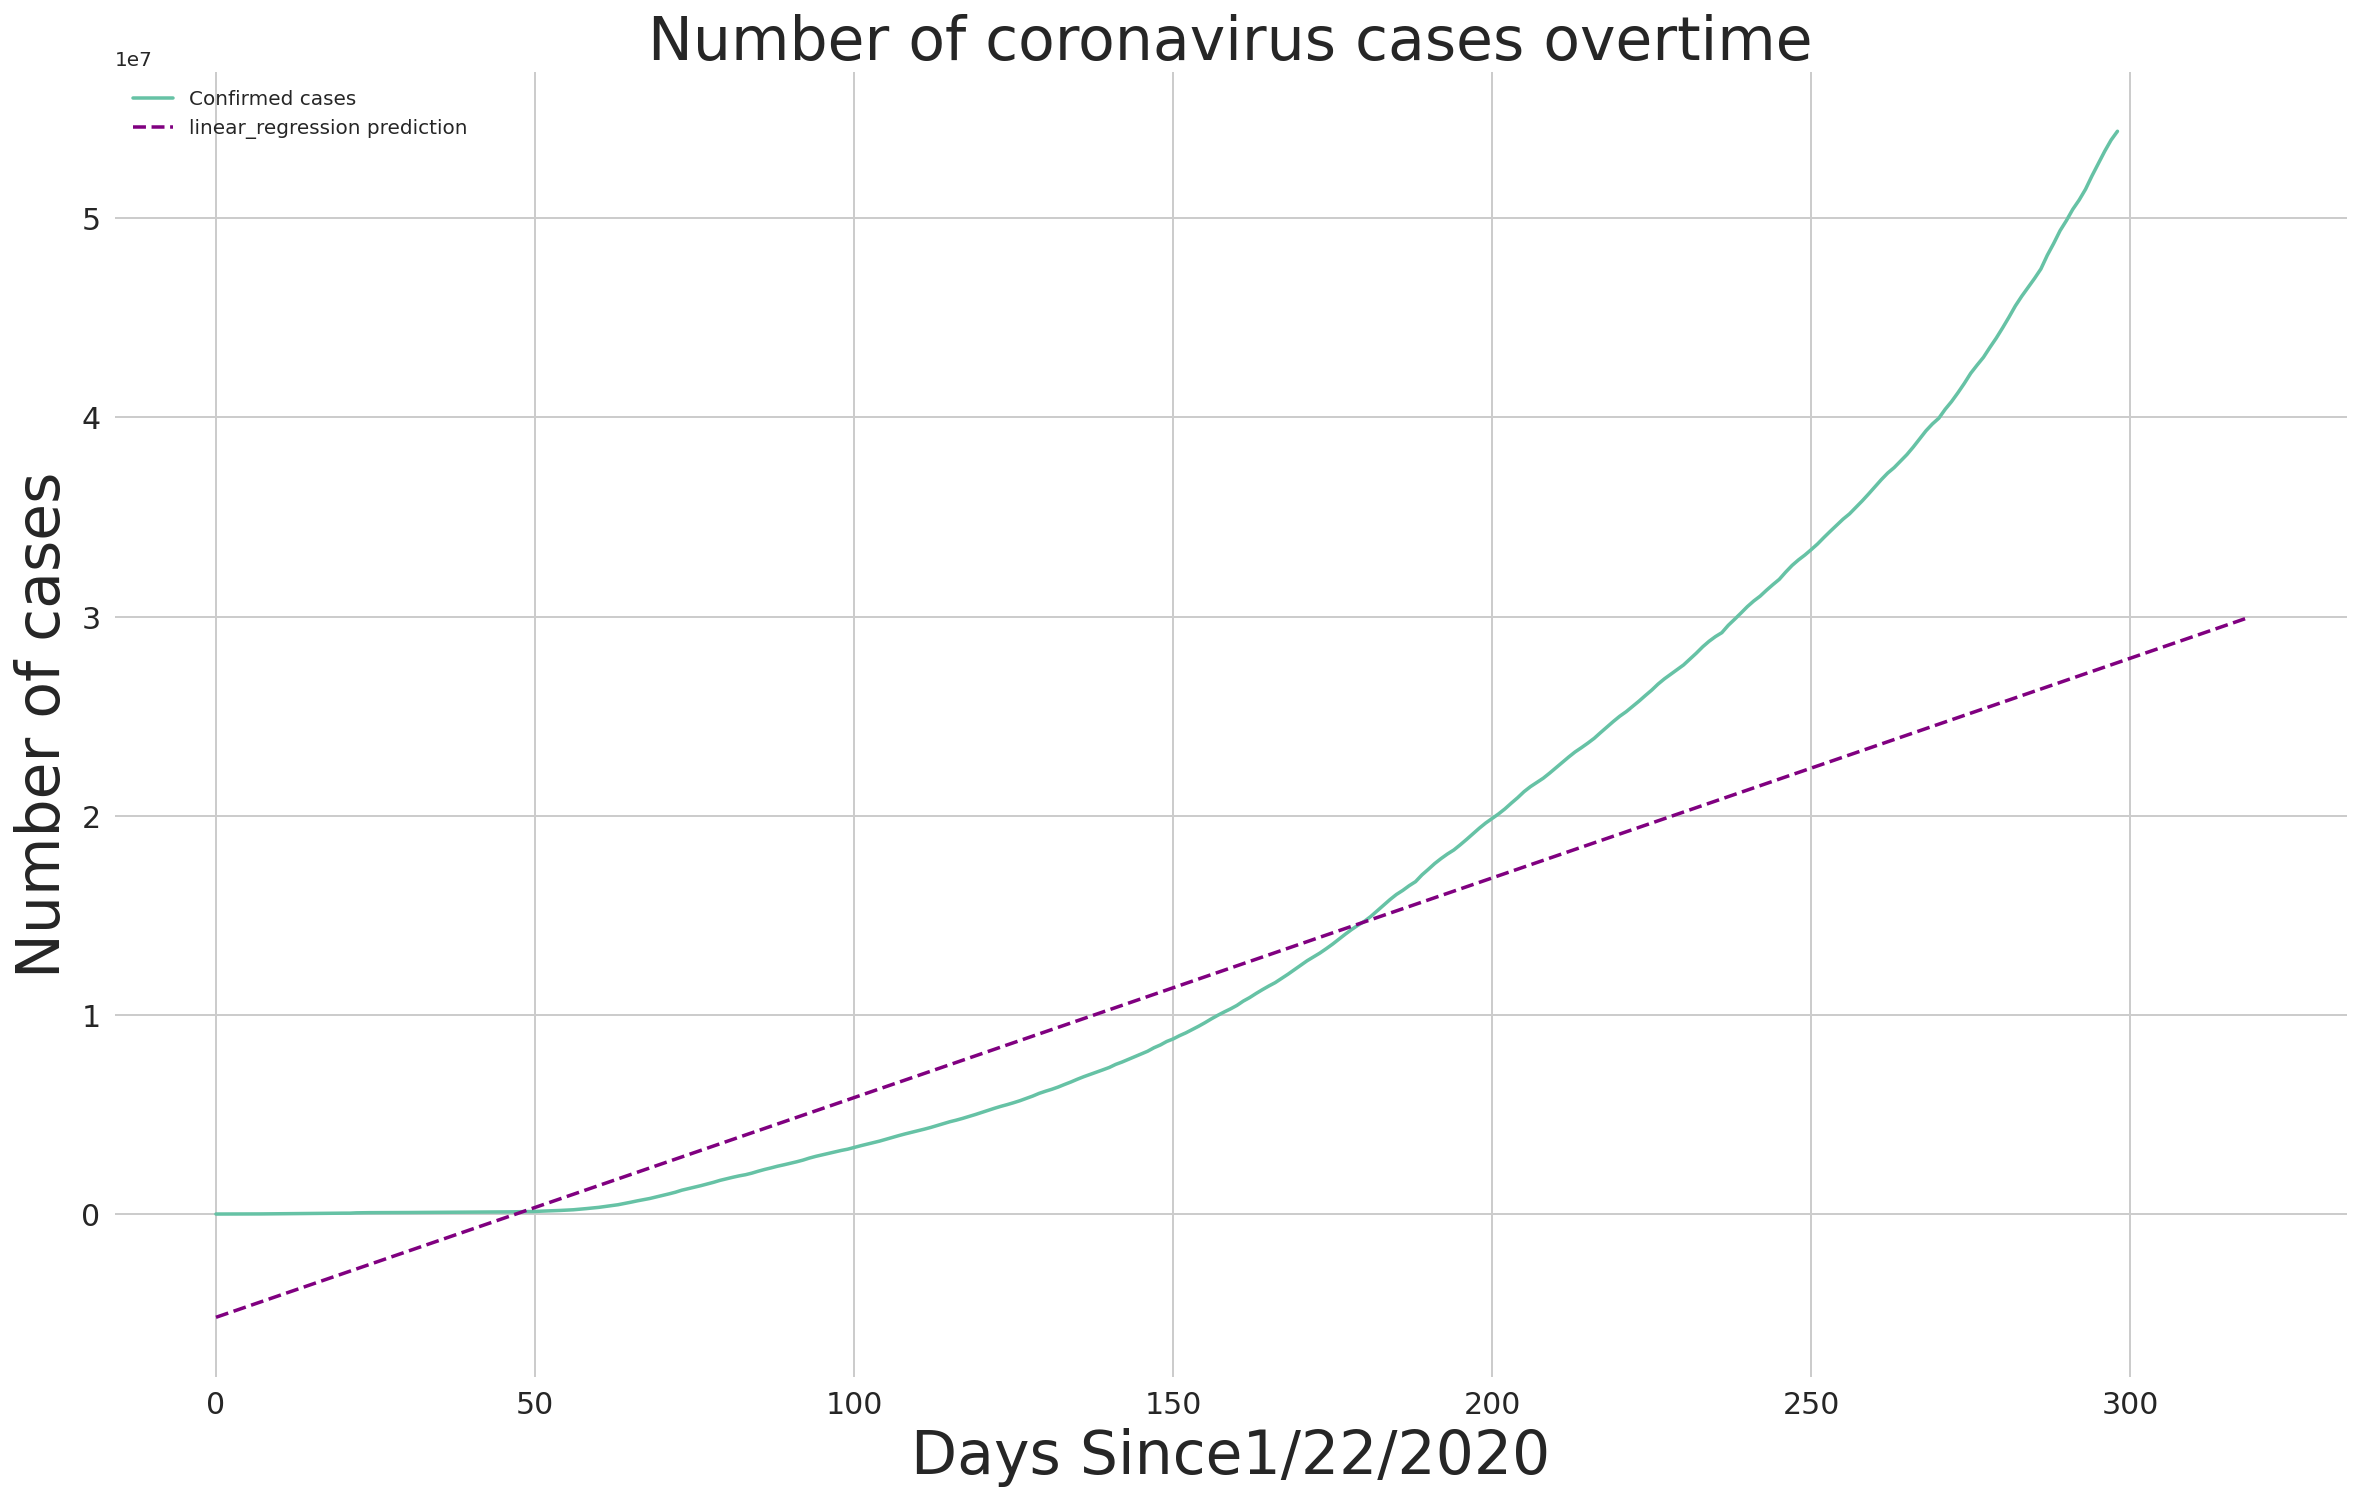

In [43]:
# confirmed vs predicted(linear_model) 
plt.figure(figsize=(20,12))
plt.plot(adjusted_dates,total_confirmed)
plt.plot(future_forecast,linear_pred,linestyle='dashed',color='purple')
plt.title('Number of coronavirus cases overtime',size=30)
plt.xlabel('Days Since1/22/2020',size=30)
plt.ylabel('Number of cases',size=30)
plt.legend(['Confirmed cases','linear_regression prediction'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [44]:
error_test_cp = y_test_confirmed - test_linear_pred
# Find MAPE
MAPE = np.mean(np.abs(error_test_cp / y_test_confirmed * 100))
print("Value of MAPE is: ", MAPE)
accuracy = 100 - MAPE
print("Accuracy of the model is", accuracy, "%.")

Value of MAPE is:  36.453219652894894
Accuracy of the model is 63.546780347105106 %.


In [45]:
#prediction for the next 10 days using LR

print(linear_pred[-20:])

[[27797611.78815664]
 [27907919.88581252]
 [28018227.9834684 ]
 [28128536.08112428]
 [28238844.17878017]
 [28349152.27643605]
 [28459460.37409193]
 [28569768.47174782]
 [28680076.5694037 ]
 [28790384.66705958]
 [28900692.76471547]
 [29011000.86237135]
 [29121308.96002723]
 [29231617.05768311]
 [29341925.155339  ]
 [29452233.25299488]
 [29562541.35065076]
 [29672849.44830665]
 [29783157.54596253]
 [29893465.64361842]]


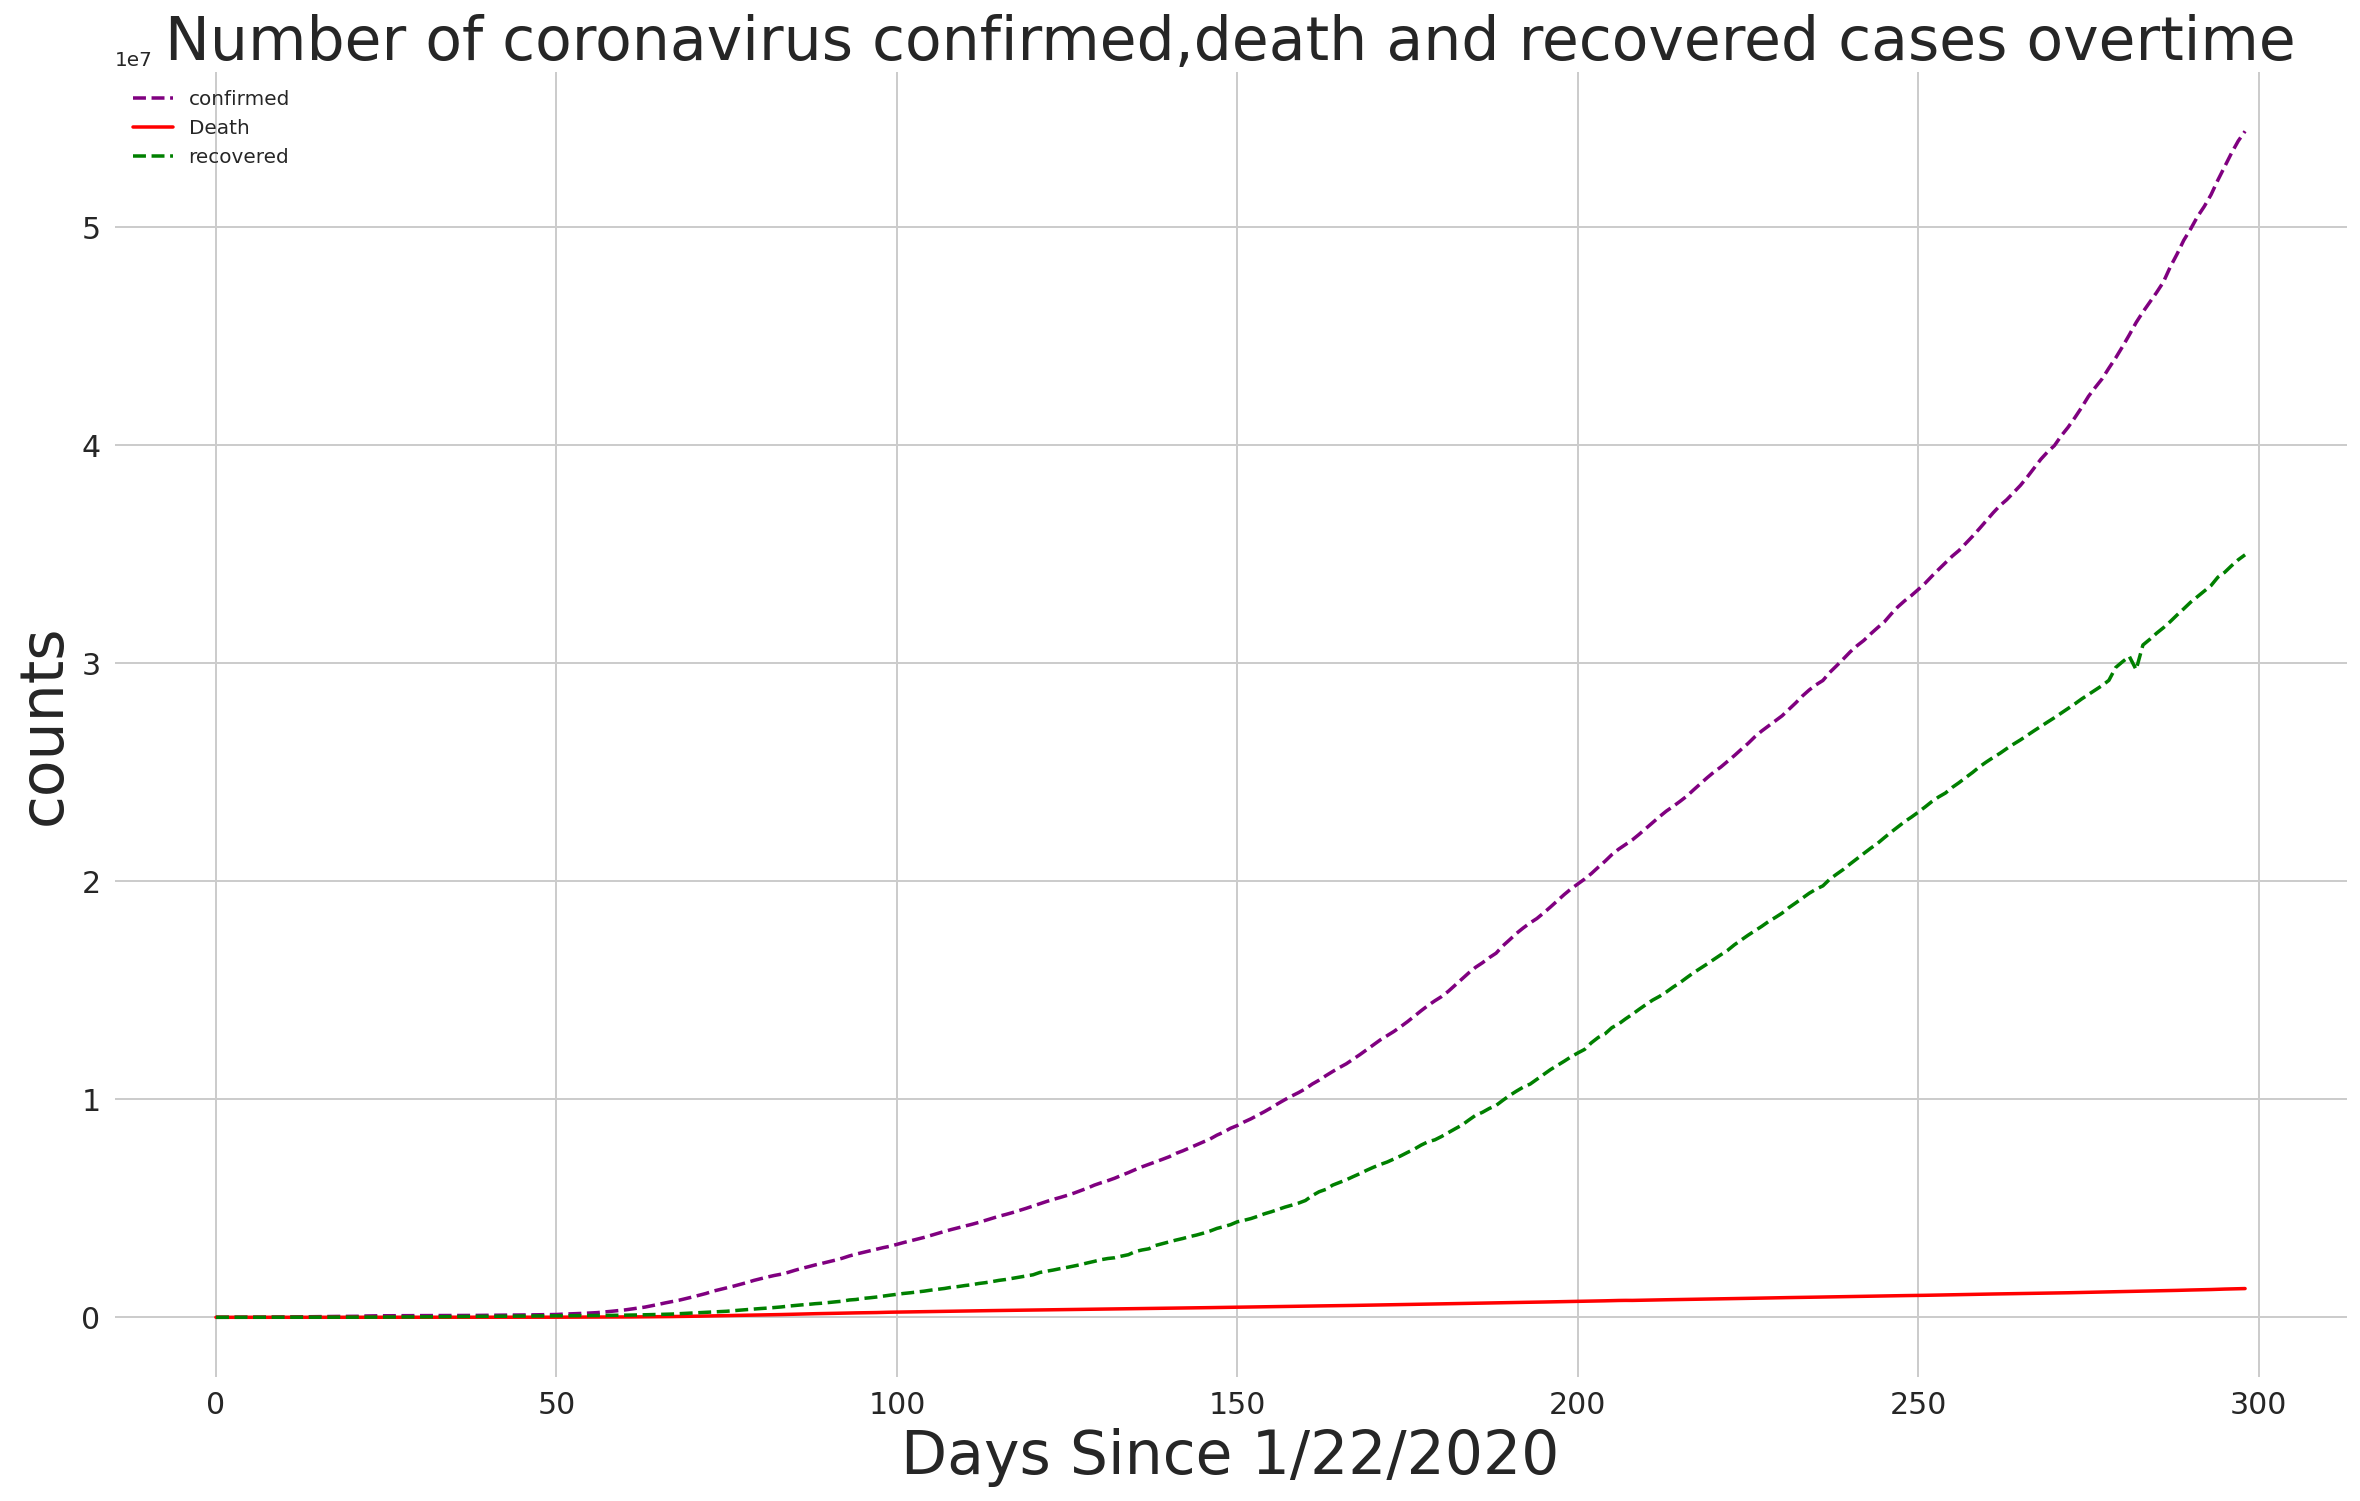

In [46]:
#plot death,confirmed and recovey cases
plt.figure(figsize=(20,12))
plt.plot(days,total_confirmed,linestyle='dashed',color='purple')

plt.plot(days,total_death,color='red')
plt.plot(days,total_recover,linestyle='dashed',color='green')

plt.title('Number of coronavirus confirmed,death and recovered cases overtime',size=30)
plt.xlabel('Days Since 1/22/2020',size=30)
plt.ylabel('counts',size=30)
plt.legend(['confirmed','Death','recovered'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()